In [1]:
import os, signal, sys

import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import conv1d
import torchvision

from time import time

sys.path.insert(0, '../')
import musicnet
from helperfunctions import get_audio_segment, get_piano_roll, export_midi
from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

import matplotlib.pyplot as plt

from pypianoroll import Multitrack, Track, load, parse

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window - n_fft)//stride

In [3]:
class CNN(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(CNN, self).__init__()      
        # Create filter windows
        wsin, wcos = musicnet.create_filters(n_fft,k, low=50, high=6000,
                                      windowing="hann", freq_scale='log')
        self.wsin = torch.Tensor(wsin)
        self.wcos = torch.Tensor(wcos)               
        # Creating Layers
        
        k_out = 128
        k2_out = 256
        self.CNN_freq = nn.Conv2d(1,k_out,
                                kernel_size=(128,1),stride=(2,1))
        self.CNN_time = nn.Conv2d(k_out,k2_out,
                                kernel_size=(1,25),stride=(1,1))        
        self.linear = torch.nn.Linear(k2_out*193, m, bias=False)

        # Initialize weights
            # Do something
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2) # shape = (batch, 512,25)
        zx = torch.log(zx + 1e-12)
        z2 = torch.relu(self.CNN_freq(zx.unsqueeze(1))) # Make channel as 1 (N,C,H,W) shape = [10, 128, 193, 25]
        z3 = torch.relu(self.CNN_time(z2)) # shape = [10, 256, 193, 1]
        y = self.linear(torch.relu(torch.flatten(z3,1)))
        return y

In [4]:
model = CNN()
model = model.to(device)

In [5]:
model.load_state_dict(torch.load('../weights/translation_invariant_baseline'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
folder = '../data/test_data/'
files = ['1759.bin', '2106.bin', '2382.bin', '2556.bin']
filepath_list = [os.path.join(folder, i) for i in files]

In [7]:
for filepath in filepath_list:
    Y_pred = get_piano_roll(filepath, model, device,
                                window=window, m=m, stride=512)
    Yhatpred = Y_pred.cpu().numpy() > 0.4
    export_midi(Yhatpred, './midi_output/CNN_{}_{}_Y_pred.mid'.format('transcription_',os.path.basename(filepath)[:-4]))

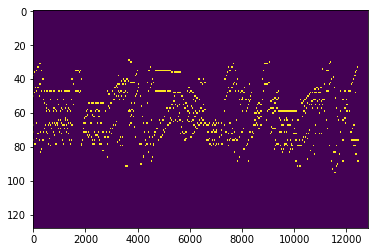

In [8]:
plt.imshow(np.transpose(Y_pred.cpu()>0.4), aspect='auto')